<a href="https://colab.research.google.com/github/anudeepayina/AerofoilPressurePrediction/blob/main/Predicting%20Pressure%20Distribution%20Over%20an%20Aerofoil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_re_5 = pd.read_csv("/content/Reynolds number = 5e5 alpha = 2-22.csv")
data_re_6 = pd.read_csv("/content/Reynolds Number = 6e6 alpha = 2-22.csv")

In [ ]:
data_re_5["Reynolds Number"] = 5000000
data_re_6["Reynolds Number"] = 6000000 

In [ ]:
data_re_5 = data_re_5[0:16160]
data = data_re_5.append(data_re_6)
data.shape

(32320, 5)

In [ ]:
n = list(range(0,204,2))
label = []
for num in n:
  label.append(data.iloc[160*num:160*(num+1),:])
train = pd.concat(label)
train = train.reset_index(drop=True)
test = data.merge(train, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
test = test.drop('_merge',axis=1)
test = test.reset_index(drop=True)

In [ ]:
x_train = train.drop("Cp",axis=1).to_numpy()
y_train = train["Cp"].to_numpy()
x_test = test.drop("Cp",axis=1).to_numpy()
y_test = test["Cp"].to_numpy()
dim = x_train.shape

**Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeRegressor()

In [ ]:
params = {"criterion": ["mse","mae"],
          "splitter": ["best","random"],
          #"max_depth": [w for w in range(0,30,1)],
          "min_samples_split": [w for w in range(1,5,1)]}

In [ ]:
gridsearch = GridSearchCV(estimator = dt, param_grid=params , scoring="neg_root_mean_squared_error",n_jobs=3,cv=3)

In [ ]:
gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=3,
             param_grid={'criterion': ['mse', 'mae'],
                         'min_samples_split': [1, 2, 3, 4],
                         'splitter': ['best'

In [ ]:
gridsearch.best_score_

-0.09465539934931162

In [ ]:
gridsearch.best_params_

{'criterion': 'mse', 'min_samples_split': 2, 'splitter': 'best'}

In [ ]:
dt = DecisionTreeRegressor(criterion = "mse", splitter = "best", min_samples_split =2)

In [ ]:
dt.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
yhat = dt.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
score_decisiontree = sqrt(mean_squared_error(y_test,yhat))

In [ ]:
start = 0
end = start + 160

while end < 16160:
  example = test.loc[start:end,["x","Cp"]]
  example.set_index("x",inplace=True)
  first_pred = pd.DataFrame(yhat[start:end],test["x"][start:end])
  first_pred.rename(columns={0:"Predicted Cp"},inplace=True)
  ax = example.plot()
  first_pred.plot(ax=ax)
  plt.grid()
  plt.title("alfa =" + str(test.iloc[start,3])+"  ""Re =" + str(test.iloc[start,4]))
  plt.savefig(str("DT: alfa =" + str(test.iloc[start,3])+"Re =" + str(test.iloc[start,4]))+".png")
  start += 160
  end = start + 160

In [ ]:
test.loc[8000:,"alfa"].unique()

array([ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ,
        6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. , 10.4,
       10.8, 11.2, 11.6, 12. , 12.4, 12.8, 13.2, 13.6, 14. , 14.4, 14.8,
       15.2, 15.6, 16. , 16.4, 16.8, 17.2, 17.6, 18. , 18.4, 18.8, 19.2,
       19.6, 20. , 20.4, 20.8, 21.2, 21.6, 22. ])

In [ ]:
re_5_test = test.loc[0:7920,"alfa"].unique()
re_6_test = test.loc[8000:,"alfa"].unique()

In [ ]:
import math
average_rmse = []
total_rmse = 0
for i in test.index:
  rmse = (test.loc[i,"Cp"] - yhat[i])**2
  total_rmse += rmse
  if i % 160 == 0:
    average_rmse.append(math.sqrt(total_rmse/160))
    total_rmse = 0
average_rmse_re_5 = average_rmse[0:50]
average_rmse_re_6 = average_rmse[50:]
val = test["alfa"].unique()
average_rmse_re_5 = pd.DataFrame(average_rmse_re_5,re_5_test)
average_rmse_re_5.rename(columns={0:"Reynolds Number = 5e6"},inplace=True)
average_rmse_re_6 = pd.DataFrame(average_rmse_re_6,re_6_test)
average_rmse_re_6.rename(columns={0:"Reynolds Number = 6e6"},inplace=True)
# average_rmse.rename(columns={0:"RMSE"},inplace=True)
# average_rmse.plot(kind="line") 
# plt.grid()
# plt.savefig("RMSE across angle of attacks with Varied Reynolds Number - Decision Tree Regressor.png")

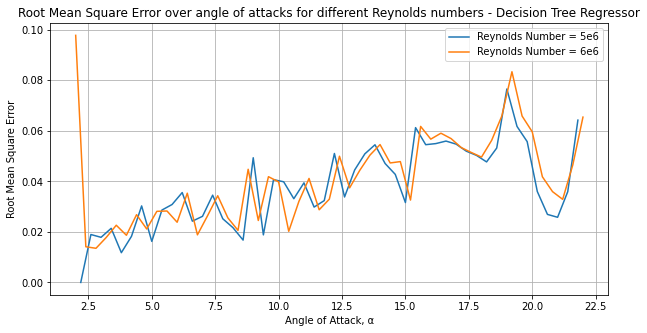

In [ ]:
ax = average_rmse_re_5.plot(figsize=(10,5))
average_rmse_re_6.plot(ax=ax)
plt.grid()
plt.xlabel("Angle of Attack, \u03B1")
plt.ylabel("Root Mean Square Error")
plt.title("Root Mean Square Error over angle of attacks for different Reynolds numbers - Decision Tree Regressor")
plt.savefig("Root Mean Square Error over angle of attacks for different R numbers - DT")

In [ ]:
average_rmse_xpoints = []
total_rmse = 0
i = 0
while i < 160:
  end = i
  while end < 8000:
    rmse = math.sqrt((test.loc[end,"Cp"] - yhat[end])**2)
    total_rmse += rmse
    end += 160
  average_rmse_xpoints.append(total_rmse/50)
  total_rmse = 0
  i += 1

average_rmse_xpoints_re_5 = pd.DataFrame(average_rmse_xpoints,test["x"][0:160])
average_rmse_xpoints_re_5.rename(columns={0:"Reynolds number = 5e6"},inplace=True)

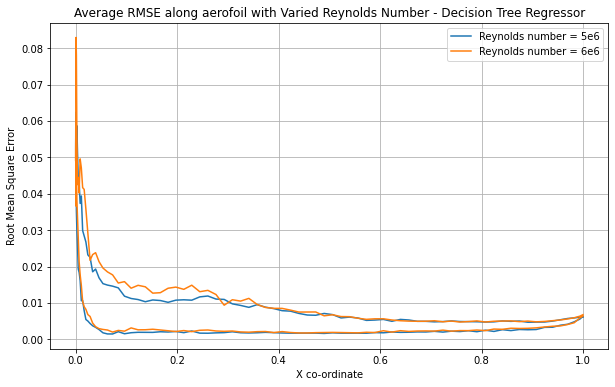

In [ ]:
average_rmse_xpoints = []
total_rmse = 0
i = 0
while i < 160:
  end = i + 8000
  while end < 16160:
    rmse = math.sqrt((test.loc[end,"Cp"] - yhat[end])**2)
    total_rmse += rmse
    end += 160
  average_rmse_xpoints.append(total_rmse/50)
  total_rmse = 0
  i += 1

average_rmse_xpoints_re_6 = pd.DataFrame(average_rmse_xpoints,test["x"][0:160])
average_rmse_xpoints_re_6.rename(columns={0:"Reynolds number = 6e6"},inplace=True)

ax = average_rmse_xpoints_re_5.plot(figsize=(10,6))
average_rmse_xpoints_re_6.plot(ax=ax)
plt.grid()
plt.xlabel("X co-ordinate")
plt.ylabel("Root Mean Square Error")
plt.title("Average RMSE along aerofoil with Varied Reynolds Number - Decision Tree Regressor")
plt.savefig("Average RMSE along aerofoil with Varied Reynolds Number - Decision Tree Regressor.png")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [ ]:
params = {"n_estimators": [5,10,20,30,40,50,60,70,80,90,100],
          "min_samples_split": [w for w in range(0,3,1)]
          }

In [ ]:
gs = GridSearchCV(estimator=rf,param_grid=params , scoring="neg_root_mean_squared_error",n_jobs=3,cv=3)

In [ ]:
gs.fit(x_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
gs.best_score_

-0.09551320050312696

In [ ]:
gs.best_params_

{'min_samples_split': 2, 'n_estimators': 70}

In [ ]:
rf = RandomForestRegressor(min_samples_split=2,n_estimators=100)

In [ ]:
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
yhat = rf.predict(x_test)

In [ ]:
score_random_forest = math.sqrt(mean_squared_error(y_test,yhat))
print(score_random_forest)

0.027045866889972996


In [ ]:
print("Decision Tree RMSE:", score_decisiontree,"|", "Random Forest RMSE:", score_random_forest)

Decision Tree RMSE: 0.04573870410996583 | Random Forest RMSE: 0.027045866889972996


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

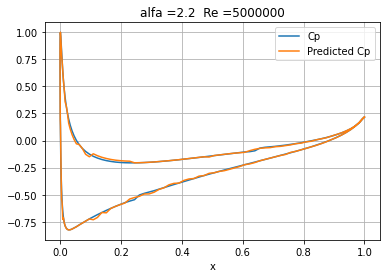

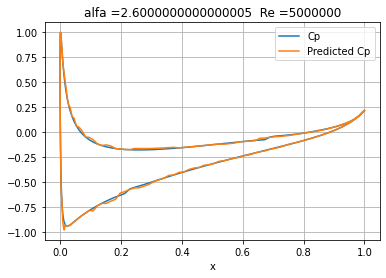

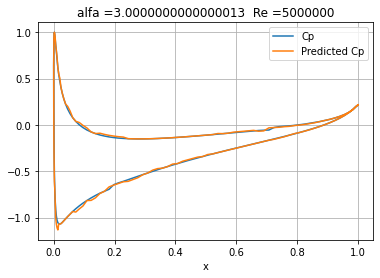

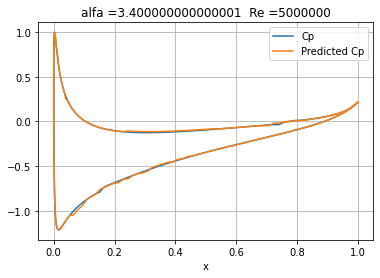

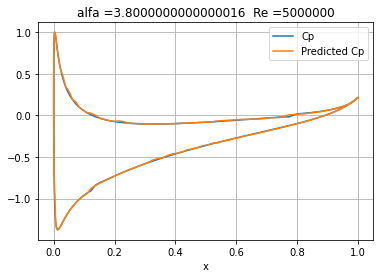

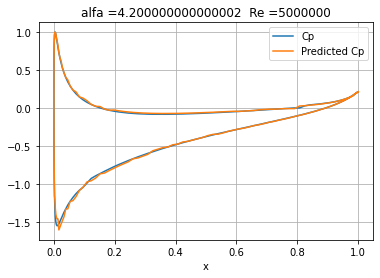

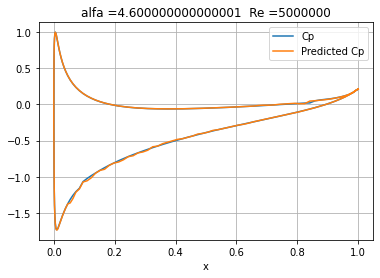

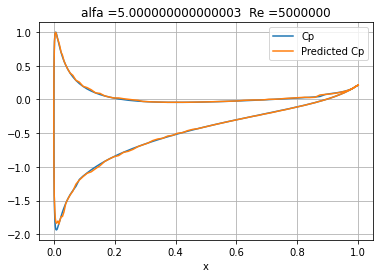

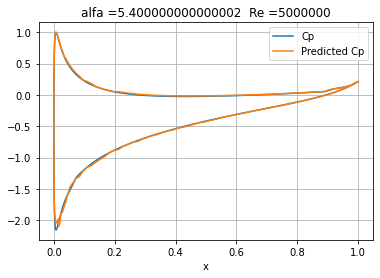

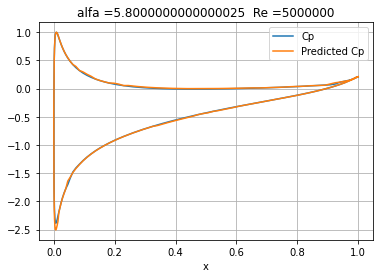

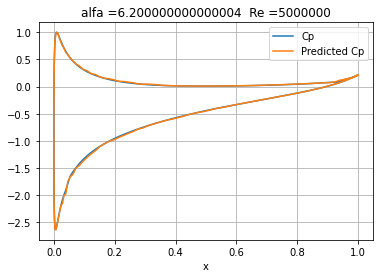

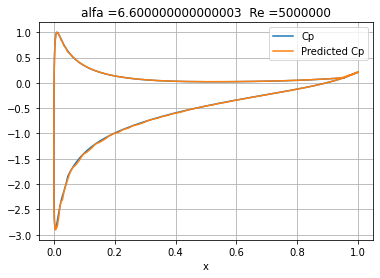

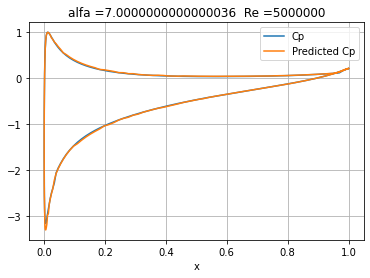

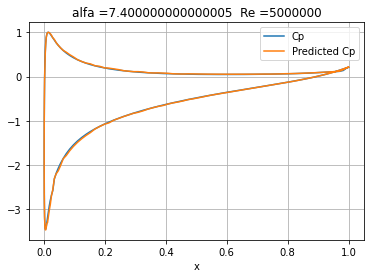

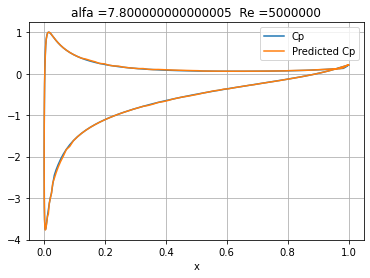

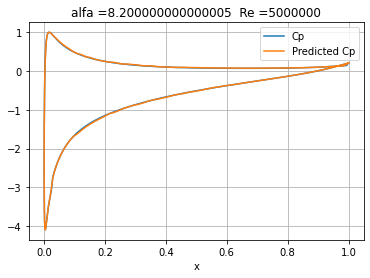

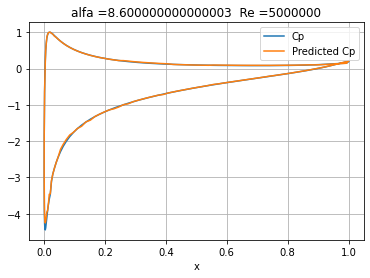

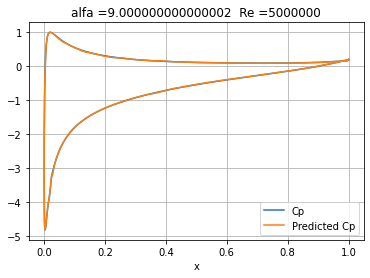

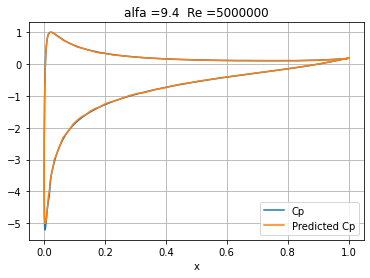

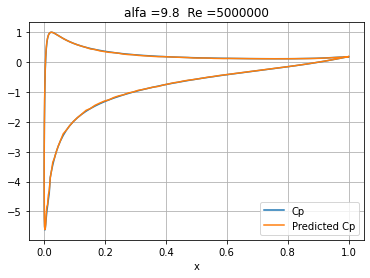

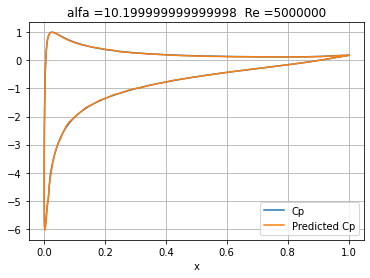

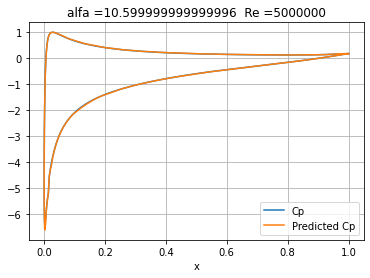

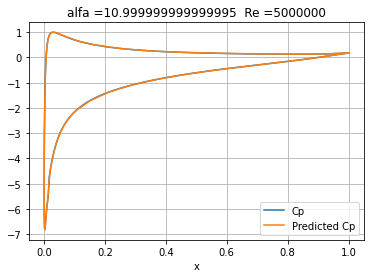

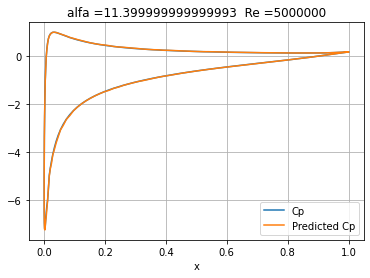

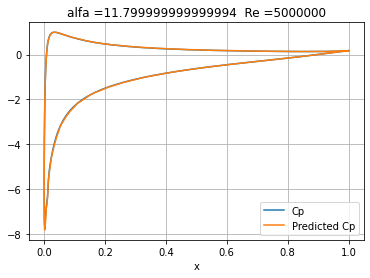

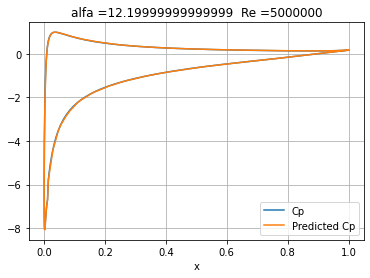

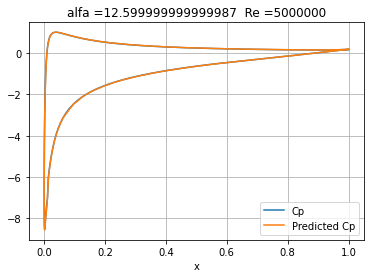

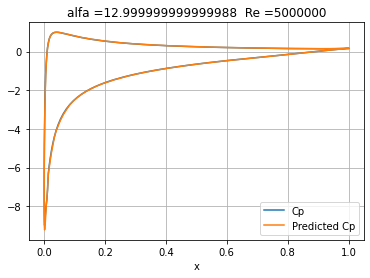

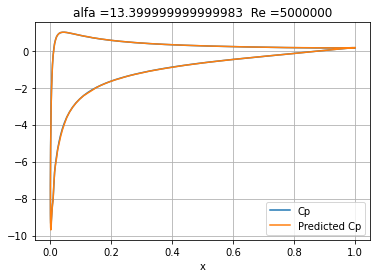

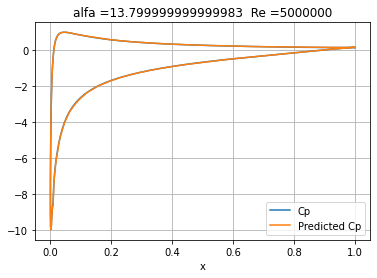

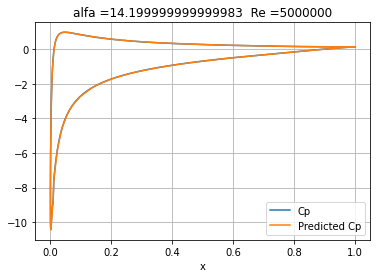

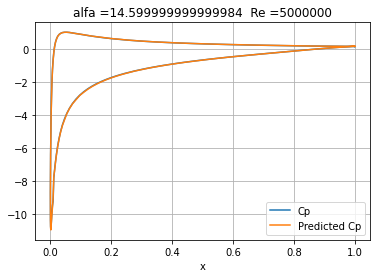

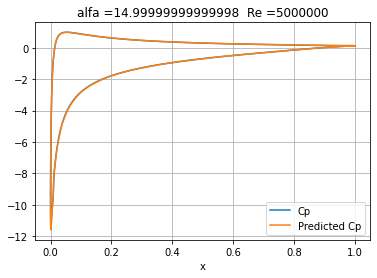

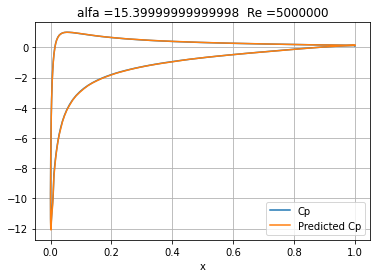

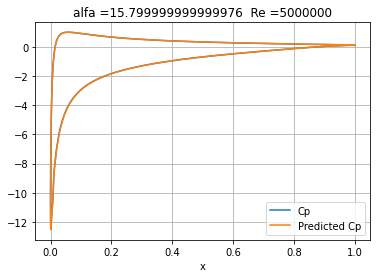

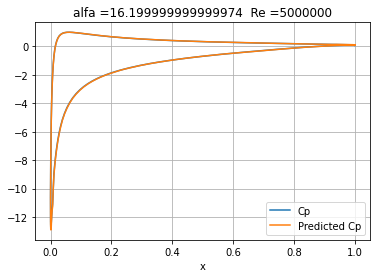

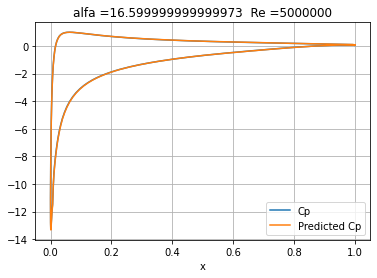

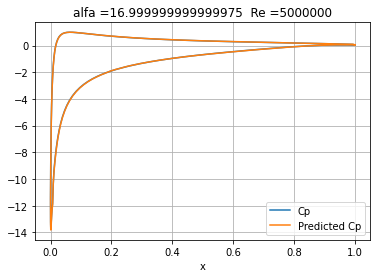

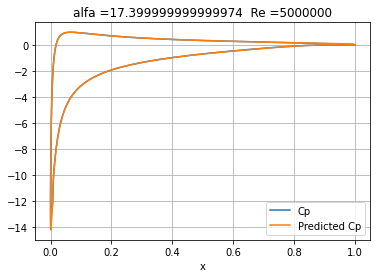

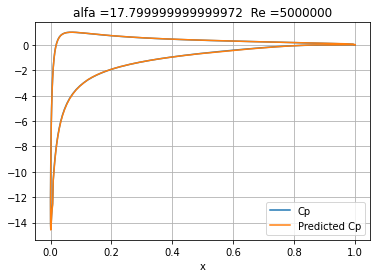

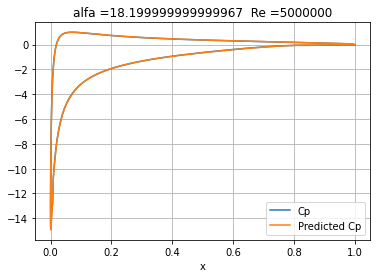

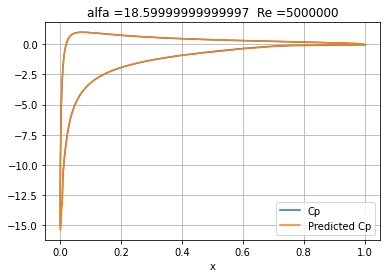

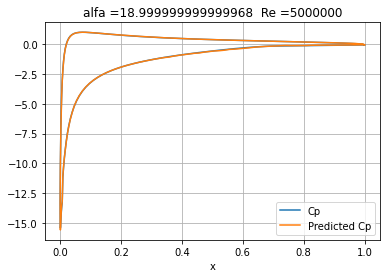

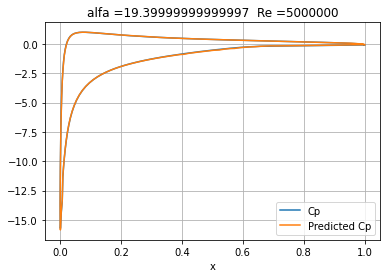

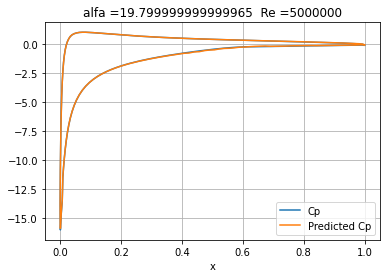

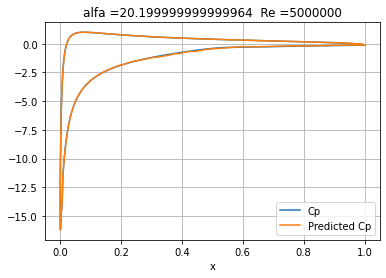

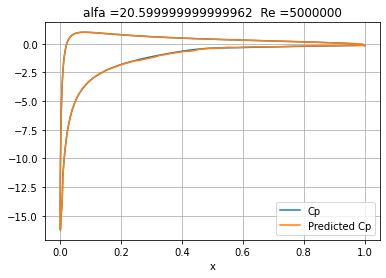

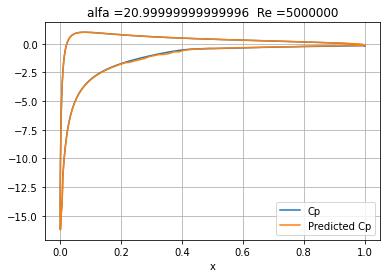

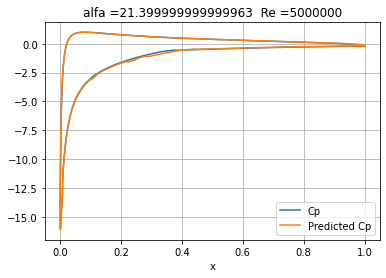

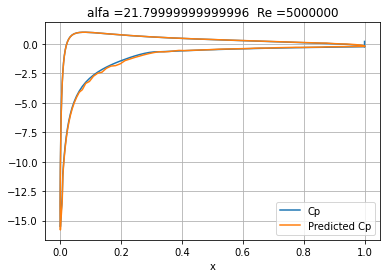

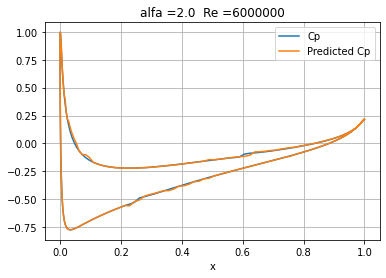

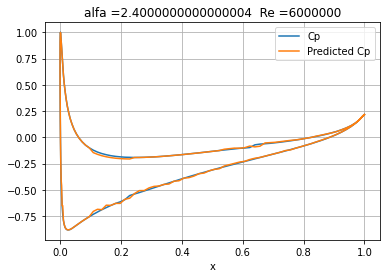

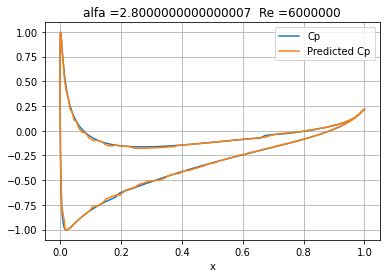

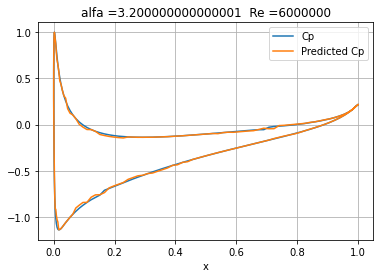

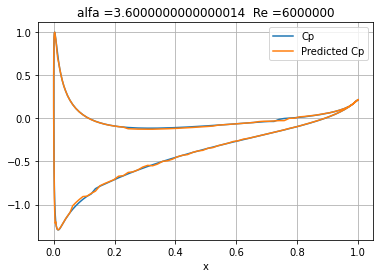

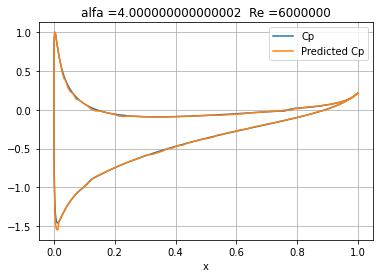

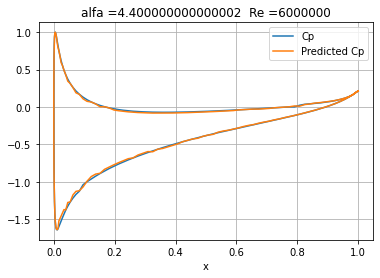

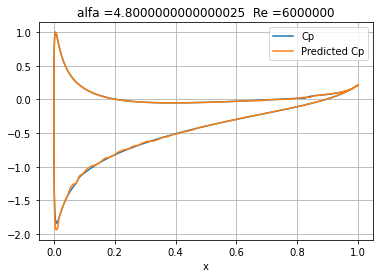

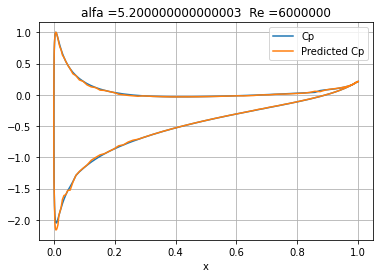

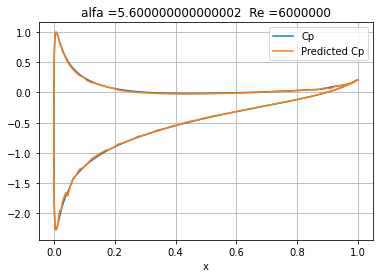

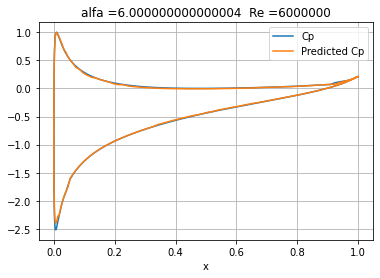

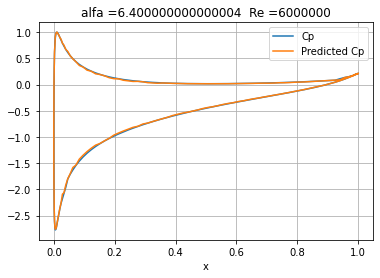

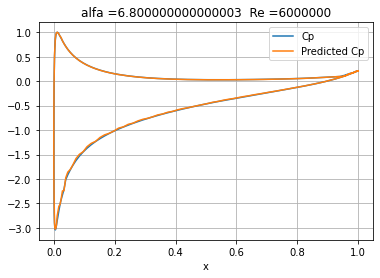

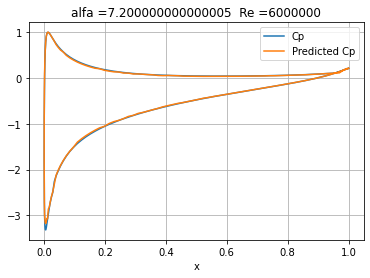

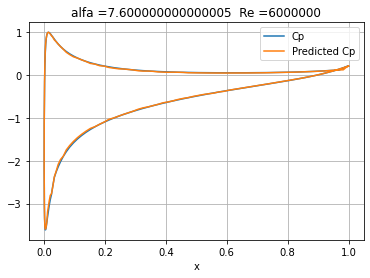

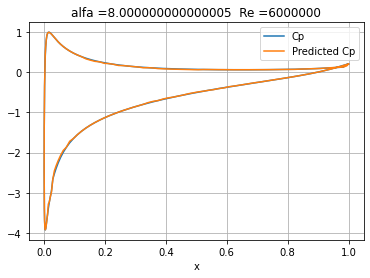

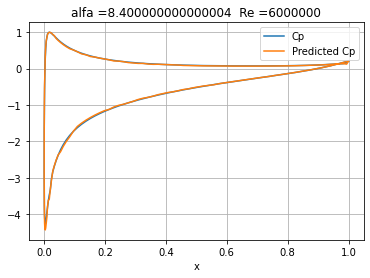

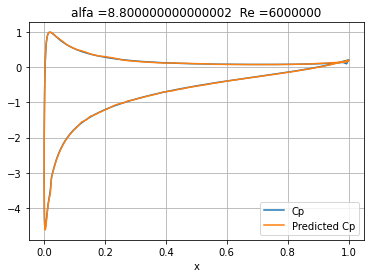

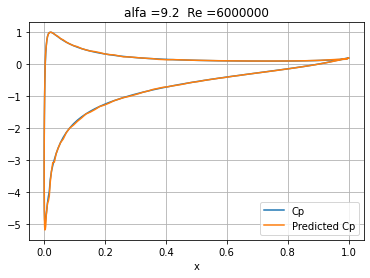

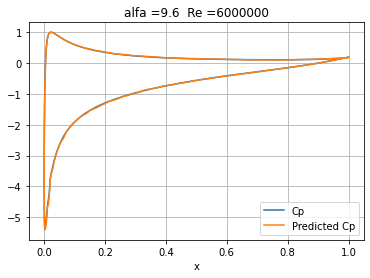

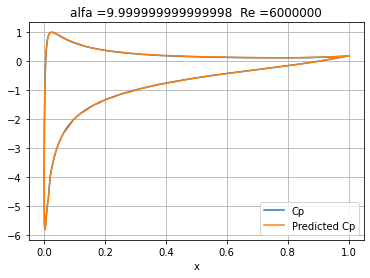

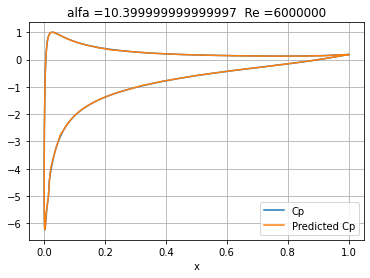

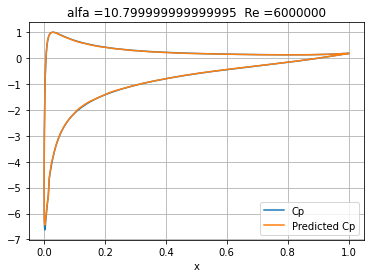

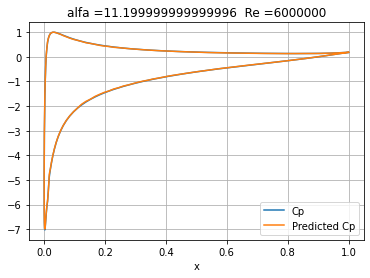

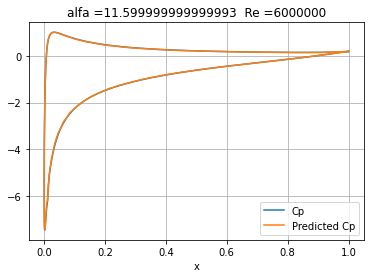

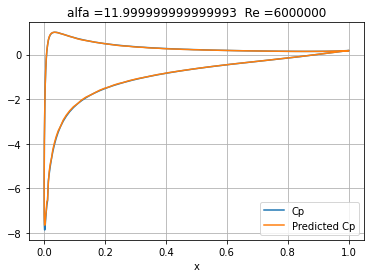

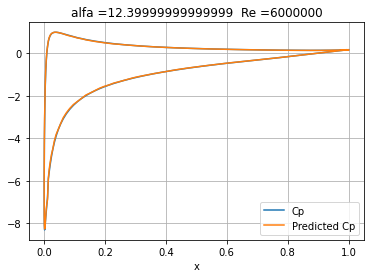

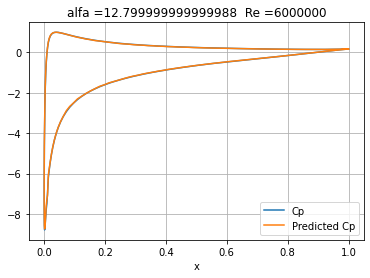

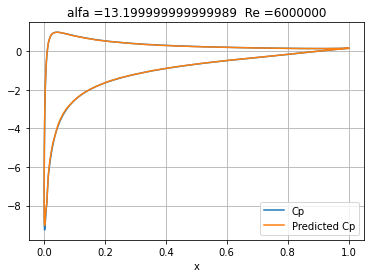

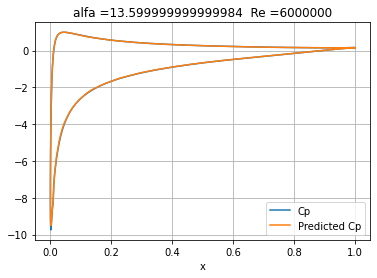

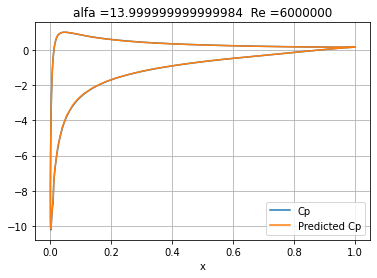

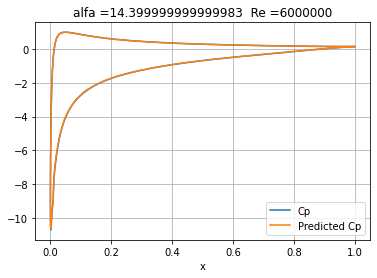

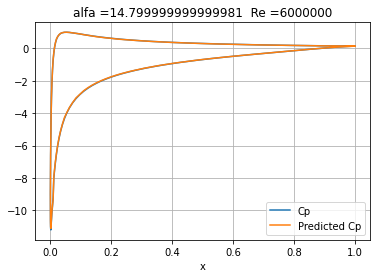

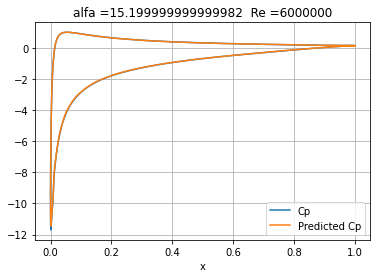

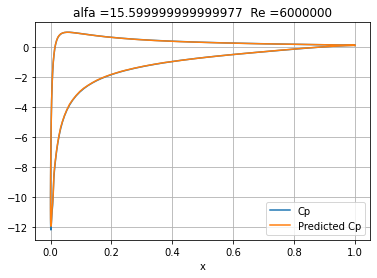

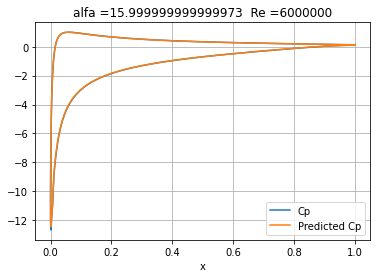

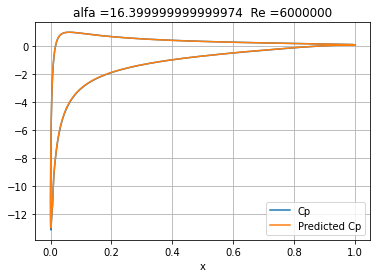

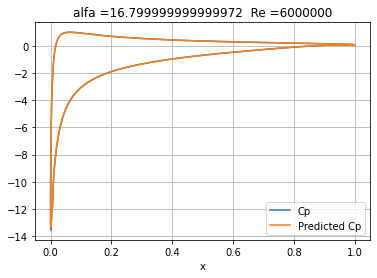

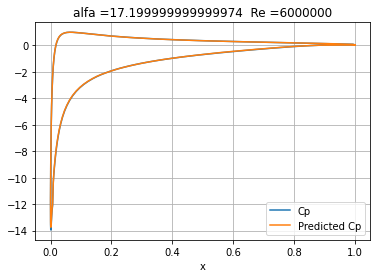

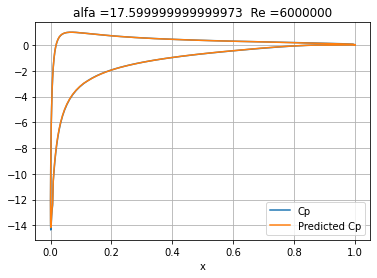

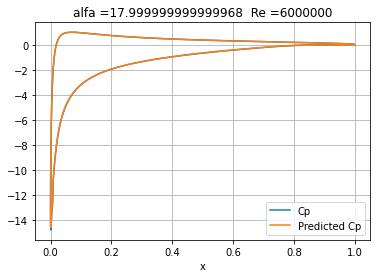

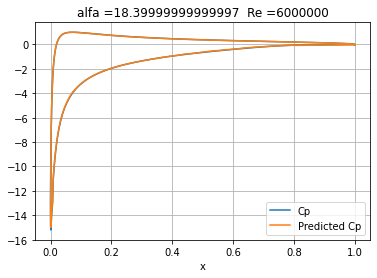

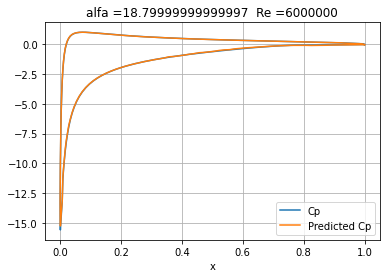

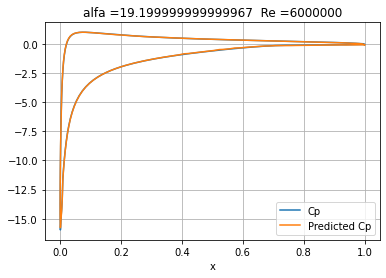

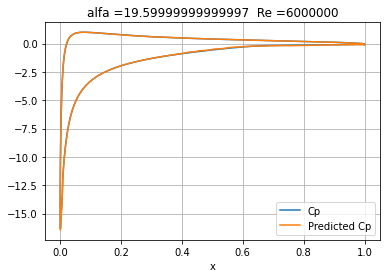

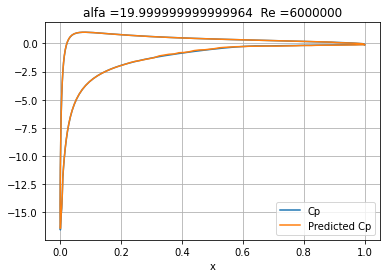

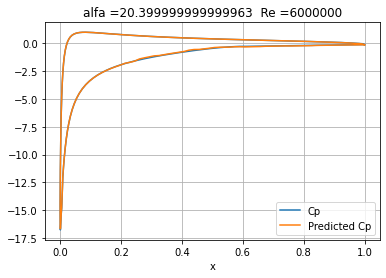

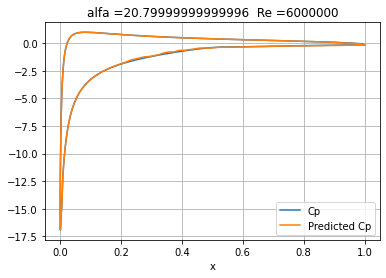

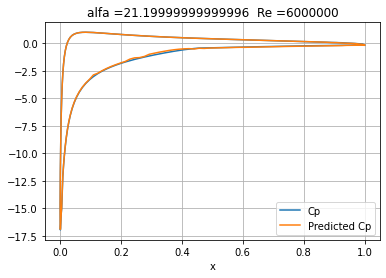

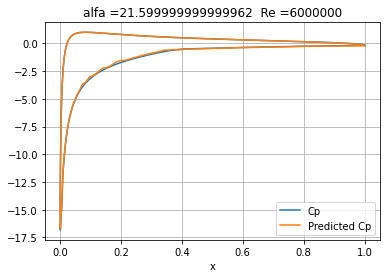

In [ ]:
start = 0
end = start + 160

while end < 16160:
  example = test.loc[start:end,["x","Cp"]]
  example.set_index("x",inplace=True)
  first_pred = pd.DataFrame(yhat[start:end],test["x"][start:end])
  first_pred.rename(columns={0:"Predicted Cp"},inplace=True)
  ax = example.plot()
  first_pred.plot(ax=ax)
  plt.grid()
  plt.title("alfa =" + str(test.iloc[start,3])+"  ""Re =" + str(test.iloc[start,4]))
  #plt.savefig(str("RF: alfa =" + str(test.iloc[start,3])+"Re =" + str(test.iloc[start,4]))+".png")
  start += 160
  end = start + 160

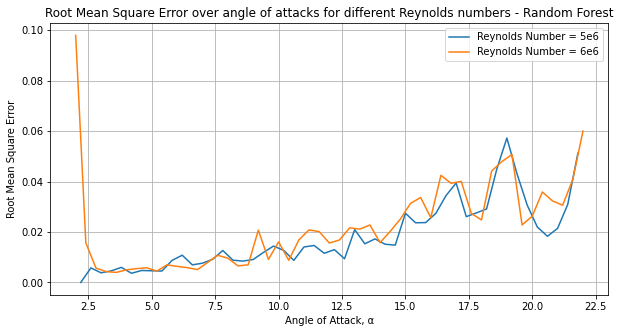

In [ ]:
average_rmse = []
total_rmse = 0
for i in test.index:
  rmse = (test.loc[i,"Cp"] - yhat[i])**2
  total_rmse += rmse
  if i % 160 == 0:
    average_rmse.append(math.sqrt(total_rmse/160))
    total_rmse = 0
average_rmse_re_5 = average_rmse[0:50]
average_rmse_re_6 = average_rmse[50:]
val = test["alfa"].unique()
average_rmse_re_5 = pd.DataFrame(average_rmse_re_5,re_5_test)
average_rmse_re_5.rename(columns={0:"Reynolds Number = 5e6"},inplace=True)
average_rmse_re_6 = pd.DataFrame(average_rmse_re_6,re_6_test)
average_rmse_re_6.rename(columns={0:"Reynolds Number = 6e6"},inplace=True)
ax = average_rmse_re_5.plot(figsize=(10,5))
average_rmse_re_6.plot(ax=ax)
plt.grid()
plt.xlabel("Angle of Attack, \u03B1")
plt.ylabel("Root Mean Square Error")
plt.title("Root Mean Square Error over angle of attacks for different Reynolds numbers - Random Forest")
plt.savefig("Root Mean Square Error over angle of attacks for different R numbers")

In [ ]:
average_rmse_xpoints = []
total_rmse = 0
i = 0
while i < 160:
  end = i
  while end < 8000:
    rmse = math.sqrt((test.loc[end,"Cp"] - yhat[end])**2)
    total_rmse += rmse
    end += 160
  average_rmse_xpoints.append(total_rmse/50)
  total_rmse = 0
  i += 1

average_rmse_xpoints_re_5 = pd.DataFrame(average_rmse_xpoints,test["x"][0:160])
average_rmse_xpoints_re_5.rename(columns={0:"Reynolds number = 5e6"},inplace=True)

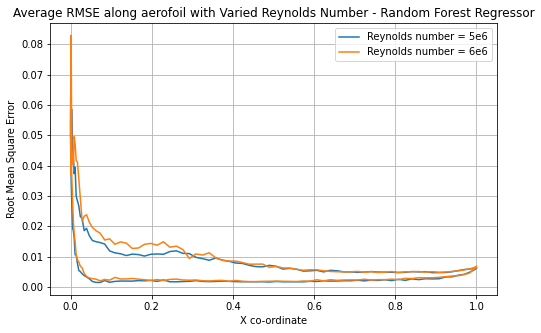

In [ ]:
average_rmse_xpoints = []
total_rmse = 0
i = 0
while i < 160:
  end = i + 8000
  while end < 16160:
    rmse = math.sqrt((test.loc[end,"Cp"] - yhat[end])**2)
    total_rmse += rmse
    end += 160
  average_rmse_xpoints.append(total_rmse/50)
  total_rmse = 0
  i += 1

average_rmse_xpoints_re_6 = pd.DataFrame(average_rmse_xpoints,test["x"][0:160])
average_rmse_xpoints_re_6.rename(columns={0:"Reynolds number = 6e6"},inplace=True)

ax = average_rmse_xpoints_re_5.plot(figsize=(8,5))
average_rmse_xpoints_re_6.plot(ax=ax)
plt.grid()
plt.xlabel("X co-ordinate")
plt.ylabel("Root Mean Square Error")
plt.title("Average RMSE along aerofoil with Varied Reynolds Number - Random Forest Regressor")
plt.savefig("Average RMSE along aerofoil with Varied Reynolds Number - Random Forest Regressor.png")